In [1]:
import matplotlib.pyplot as pp
import structure_denoise.data_io as data_io
import structure_denoise.tools as tools

In [2]:
%matplotlib inline

## Outline
The ECoG frames $x\in\mathbb{R}^{n}$ are treated as a composition of uncorrelated “field” and “artifact” components $x=p+q$. This method attempts to discover a low-rank subspace of $\mathbb{R}^{n}$ that preferentially represents $q$ artifacts having a stable, but unknown spatial structure. The subspace is formed by top-ranked eigenvectors of a sample covariance matrix (i.e. PCA) formed from approximately isolated $q$ frames. To isolate the artifact component of images, a model-based subspace is constructed to represent features of the raw frames having a level of detail learned from the length scale of the field covariance. To adapt to typical LFP power scaling, the denoising processing is made on wavelet subbands, which are then reconstructed to the full band.

The next sections illustrate the two stages of image projections. First I discuss isolating residual frames from the adaptive image space model. Second I discuss removing artifact components that project onto a subspace derived from the residuals.

## Complementary Subspace Example
We'll look at a 244-channel ECoG recording with moderate "structured" noise and find a set of basis functions to represent that structure. In the process to isolate noisy frames, the first step is to approximate the complementary subspace representing the image using a model of spatial covariance. To this end, we can use a one-parameter exponential model of covariance fit from a variogram by a simple heuristic. The variogram estimates the "semivariance" quantity
$$
\gamma (h)=E\{(x(s)-x(s-h))^{2}\}
$$
(for spatial indices $s,h$) based on all pairwise variances in the channels. It is related to the covariance by $\gamma (h)=C(0)-C(h)$, but it is a more convenient estimator in some respects. The exponential model of the covariance is simply $C(h)=\zeta \exp \{-h/\theta\}$, making the semivariance an exponential approach. The first row in the image below shows a raw ECoG frame (from a wavelet scale at ~10-25 Hz) and the corresponding variogram computed from a half-second interval.

The length scale of the exponential is estimated based on the "middle" of the variogram curve, determined by the x-value at which the variogram is midway between its 10th and 90th percentile. Then $\theta =x_{m}/\ln(2)$. As we will see, the amplitude scale $\zeta$ is not needed. The model covariance matrix can be factored into eigenvectors ranked by eigenvalues:
$$
C=V\Lambda V^{T}\\
VV^{T}=I=V^{T}V\\
diag\{\Lambda \}=(\lambda_1,\lambda_2,\dots,\lambda_{n})^{T}\\
\lambda_1>\lambda_2>\dots>\lambda_n
$$

The next rows of the figure below show how these eigenvectors can be applied to the ecog frames in a manner analagous to principal components analysis. (Note that the scale $\zeta$ only multiplies the eigenvalues but does not change their order, so it can be ignored.) As in PCA, the eigenvectors are ranked to optimally project particular images into a lower dimensional subspace. Here, the images that are best preserved have spatial features that are described by the scale of the covariance model. The image projection is calculated by finding the subspace rank that preserves P% *model* variance:
$$
r=\arg \min P<\sum_{k=1}^{r}\lambda_k \Big/ \sum_{k=1}^{n}\lambda_k\\
V_{r}=(v_{1},\dots,v_{r})\\
\tilde{x}=V_{r}V_{r}^{T}x
$$
The second figure row shows the projected image and residual based on the derived length scale and 90% model variance. The scale of image features seems visibly consistent with the raw frame. More important for isolating noise: the cross-hatch and triangle structures are fairly well represented in the residual. The next two rows of images depict the effects of over- and under-estimating the length scale $\theta$. The eigenvectors do not greatly depend on $\theta$, but rather the subspace dimension is lower or higher, capturing different amounts of detail. *To avoid losing resolution, it may be beneficial to down-bias the estimation of $\theta$.*

In [3]:
d_src = data_io.OpenEphysHDFSource('/Users/mike/experiment_data/Human_uECoG/D4_micro_1_2017-01-26_14-28-15_Fs2000.h5')
frames = d_src[10000:10000 + 2**10]

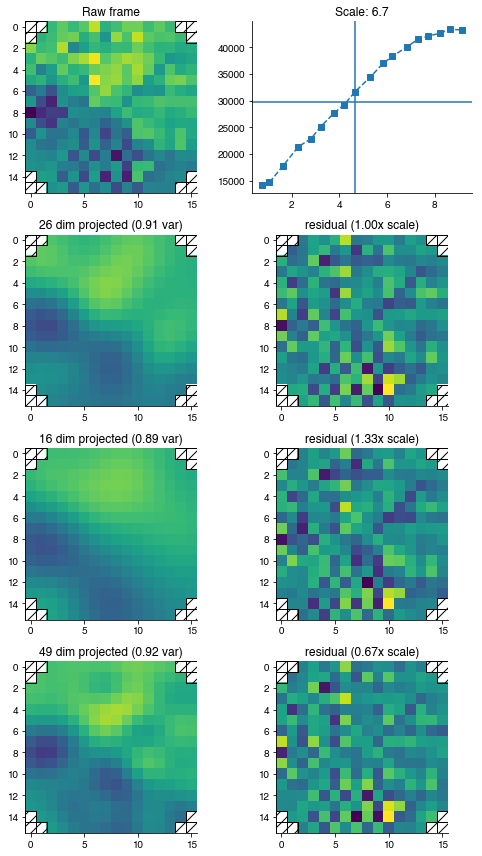

In [4]:
fig = tools.plot_projections(frames, 
                             d_src.channel_map, 
                             multiresolution=True, 
                             deviation=0.33,
                             wavelet='db2',
                             wave_level=3, 
                             model_var=0.90,
                             f_idx=410)

## Structured Artifact Subspace Example
The preceding development of image projections served the purpose of isolating a non-image residual. As a more conservative alternative to denoising through image projections, we can instead iterate the PCA process to learn an optimal basis for the residual. The advantage of this approach is that the complementary image space is based on the actual data frames, rather than the spatial covariance model.

In this example, the sample covariance of a stack of 1024 residual frames is used to form a subspace basis $M$ retaining 80% of the residual variance. The clean frames are computed as the projection $\tilde{X}=(I-M)X$. The first three rows in the figures below show low-, median- and high-variance frames before and after denoising. The cross-hatch and triangle structures are effectively isolated by the axes of $M$.

The next set of figures demonstrates the two-stage complementary subspace process. The first two eigenvectors of the *image* covariance model are shown. These low-order functions are very broad in space: the length-scale from the variogram influences how many dimensions are needed to retain 90% of model variance. The projection and residual from the median variance frame are shown in the next row. To conclude the process, the first three modes learned from the residual frames are shown in the last frame. These functions are optimal for representing the "noisiest" residual structures, and hopefully less suited for representing image detail.

Model order: 37 resid order: 5


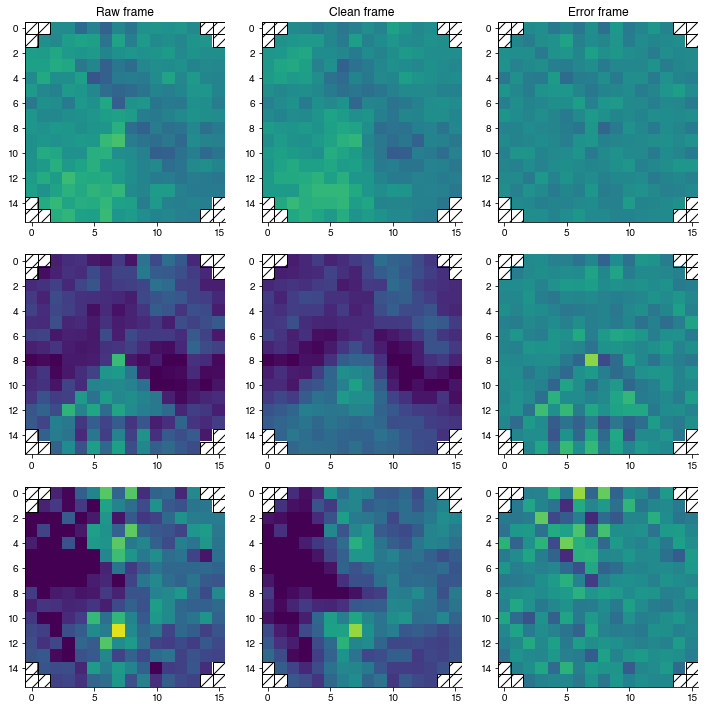

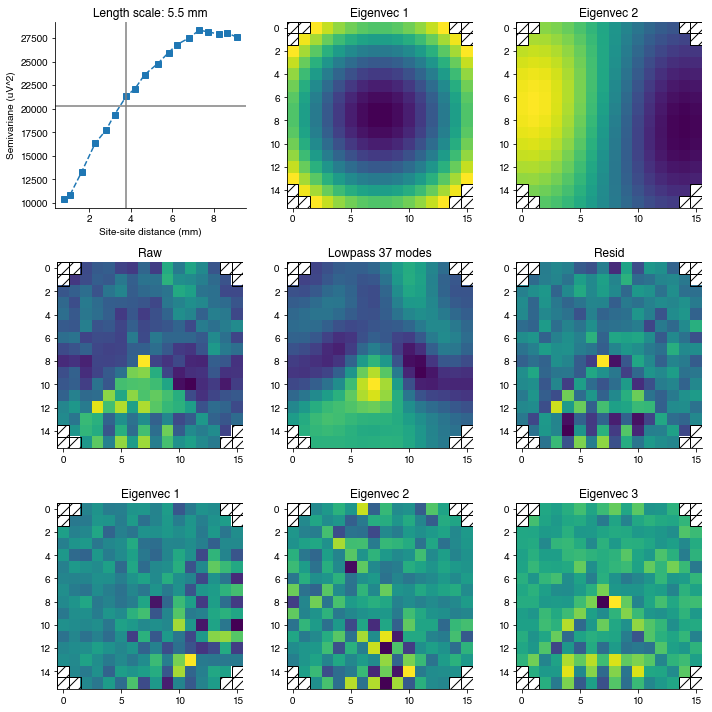

In [5]:
f1, f2 = tools.diagnostics(d_src, 
                           block_size=2 ** 10 / d_src.samp_rate, 
                           block=10,
                           multiresolution=True, 
                           wavelet='db2', 
                           wave_level=3, 
                           model_var=0.90,
                           resid_var=.80,
                           video=False,
                           save_figs=False)[::-1]